# Create a RNN model to text generation
- RNN model at character level
    - Input: n character previous
    - Output: next character
    - Model LSTM
- Use 'El Quijote' to train the generator


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


Keras version:  2.0.0


## Download data and generate sequences

Download quijote from guttenberg project

wget http://www.gutenberg.org/cache/epub/2000/pg2000.txt

In [2]:
#Read book
text = open(path + "pg2000.txt").read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('Chars list: ', chars)
print('total chars:', len(chars))

#Dictionaries to convert char to num & num to char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


corpus length: 2117498
Chars list:  ['\n', ' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '«', '»', '¿', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü', '\ufeff']
total chars: 72


In [3]:
# cut the text in semi-redundant sequences of maxlen characters
# One sentence of length 20 for each 3 characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(300, len(text) - maxlen, step): #Start in line 30 to exclude Gutenberg header.
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))
print(sentences[4996], '-', next_chars[4996])

nb sequences: 705726
tregará a medea; si  - d


## Train the model

In [4]:
'''
X: One row by sentence
    in each row a matrix of bool 0/1 of dim length_sentence x num_chars coding the sentence. Dummy variables
y: One row by sentence
    in each row a vector of bool of lengt num_chars with 1 in the next char position
'''

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('X shape: ',X.shape)
print('y shape: ',y.shape)

Vectorization...
X shape:  (705726, 20, 72)
y shape:  (705726, 72)


In [6]:
# build the model: 2 stacked LSTM
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM


print('Build model 1')
seq_prev_input = Input(shape=(maxlen, len(chars)), name='prev') 
                
# apply forwards LSTM
forwards1 = LSTM(512, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(seq_prev_input)

forwards2 = LSTM(512, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(forwards1)

output = Dense(len(chars), activation='softmax')(forwards2)

model = Model(inputs=seq_prev_input, outputs=output)
model.summary()

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 20, 72)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 512)           1198080   
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 72)                36936     
Total params: 3,334,216.0
Trainable params: 3,334,216.0
Non-trainable params: 0.0
_________________________________________________________________


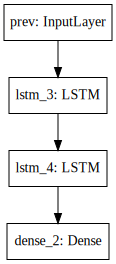

In [7]:
#Print the model
#Plot the model graph
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
#Fit model
history = model.fit(X[:600000], y[:600000], batch_size=512, epochs=50,
           validation_data=(X[600000:], y[600000:]))



Train on 600000 samples, validate on 105726 samples
Epoch 1/50
600000/600000 [==============================] - 128s - loss: 2.2960 - acc: 0.3154 - val_loss: 2.0004 - val_acc: 0.4005
Epoch 2/50
600000/600000 [==============================] - 128s - loss: 1.8696 - acc: 0.4224 - val_loss: 1.8162 - val_acc: 0.4574
Epoch 3/50
600000/600000 [==============================] - 128s - loss: 1.7005 - acc: 0.4715 - val_loss: 1.7047 - val_acc: 0.4973
Epoch 4/50
600000/600000 [==============================] - 126s - loss: 1.5980 - acc: 0.5014 - val_loss: 1.6492 - val_acc: 0.5153
Epoch 5/50
305152/600000 [==============>...............] - ETA: 58s - loss: 1.5394 - acc: 0.5184

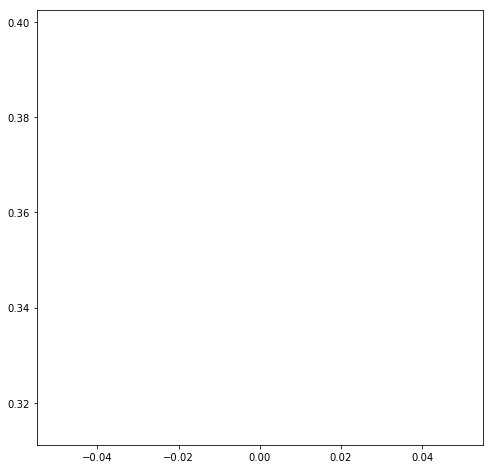

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [11]:
from keras.models import save_model

save_model(model, path + 'models/text_generation_model.h5')


## Evaluate model

In [12]:
from keras.models import load_model

model1 = load_model(path + 'models/text_generation_model.h5')


In [13]:
maxlen = 20


def sample(a, diversity=1.0):
    '''
    helper function to sample an index from a probability array
    - Diversity control the level of randomless
    '''
    a = np.log(a) / diversity
    a = np.exp(a) / np.sum(np.exp(a), axis=0)
    a /= np.sum(a+0.0000001) #Precission error
    return np.argmax(np.random.multinomial(1, a, 1))


def generate_text(sentence, diversity, current_model, num_char=400):
    sentence_init = sentence
    generated = ''
    for i in range(400):
        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.
        preds = current_model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
    print()
    print('DIVERSITY: ',diversity)
    print(sentence_init + generated)


In [15]:
sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model2)


DIVERSITY:  0.2
mire vuestra merced de la de la de la serier de la cuera de la verta que se señor de la meras de la cuello que el mer de la desta de la cante y el con la meros de la venta de la que se había de la meras de la meriento de la merer que no se la de le había de la meras de la merar a la cuerto de la merer de la cante a la meras de la desta de la ser de la de se la meros de la verta de la heres de la contero que el alla d


In [ ]:

sentence = 'mire vuestra merced '
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de lo que sucedió a'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)



sentence = 'de allí a poco come'
generate_text(sentence, 0.2, model1)
generate_text(sentence, 0.5, model1)
generate_text(sentence, 1,   model1)
generate_text(sentence, 1.2, model1)


/home/ubuntu/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log



DIVERSITY:  0.2
mire vuestra merced lo ha de ser mi señor don quijote -dijo el cura-, que estaba en la mitad del caballero de la mano, y le dijo:

-¿qué dios se le diga en la mitad del mundo, y el caballero del caballero de la mano de los de los demás de la mujer de la mano, que está en el mundo los ojos de la mano, y que la había de ser el deseo de su caballero andante, y el cura que le dijese la mano de la mano, y de la ma

DIVERSITY:  0.5
mire vuestra merced cuando le dijo:

-esto se le había de hacer más de los ojos de su grande aventura, con mucha falta de los río, y el tal se puedo preguntar por los
tres más propósitos de los dos las comedimientos de los dos de los de la vida, arrojó las alforjas de los ojos de su amo, el cual, como lo cual visto en el suelo. pero no sé qué tiempos que con los de los dos pastores con toda la cabeza de la

DIVERSITY:  1
mire vuestra merced a los amorosos que
sabes:

todos estos en el mundo que a caballero andante como los pensamientos de los escu